# Аналитика в Яндекс.Афише

Наша задача - оптимизировать маркетинговые затраты.


В нашем распоряжении есть следующие данные от Яндекс.Афиши за июнь 2017 - конец мая 2018:
* лог сервера с данными о посещениях сайта Яндекс.Афиши,
* выгрузка всех заказов за этот период,
* статистика рекламных расходов.


Чтобы в итоге порекомендовать маркетологам, **куда и сколько денег стоит вкладывать**, мы изучим следующее:
* как люди пользуются продуктом,
* когда они начинают покупать,
* сколько денег приносит каждый клиент
* когда клиент окупается.

### Оглавление

1. [Знакомство с данными](#1)
2. [Продукт](#2) <br>
2.1 [Сколько людей пользуются в день, неделю, месяц?](#2.1) <br>
2.2 [Сколько сессий в день?](#2.2) <br>
2.3 [Сколько длится одна сессия?](#2.3) <br>
2.4 [Как часто люди возвращаются?](#2.4) <br>
3. [Продажи](#3) <br>
3.1 [Когда люди начинают покупать?](#3.1) <br>
3.2 [Сколько раз покупают за период?](#3.2) <br>
3.3 [Какой средний чек?](#3.3) <br>
3.4 [Сколько денег приносят? (LTV)](#3.4) <br>
4. [Маркетинг](#4.1) <br>
4.1 [Сколько денег потратили? Всего / на каждый источник / по времени](#4.2) <br>
4.2 [Сколько стоило привлечение одного покупателя из каждого источника?](#4.3) <br>
4.3 [На сколько окупились расходы? (ROI)](#4.4) <br>
4. [Общий вывод](#5)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
import warnings
import datetime
warnings.filterwarnings('ignore')
starttime=datetime.datetime.now()

plt.style.use('seaborn-whitegrid')
sns.set_palette('Paired')



<a id="1"></a>
### 1. Знакомство с данными

1. Таблица **df1** (visits) - лог сервера с информацией о посещениях сайта:

**Uid** — уникальный идентификатор пользователя

**Device** — категория устройства пользователя

**Start Ts** — дата и время начала сессии

**End Ts** — дата и время окончания сессии

**Source Id** — идентификатор рекламного источника, из которого пришел пользователь

2. Таблица **df2** (orders) -информация о заказах:

**Uid** — уникальный id пользователя, который сделал заказ

**Buy Ts** — дата и время заказа
**Revenue** — выручка Яндекс.Афиши с этого заказа

3. Таблица **df3** (costs) - информация о затратах на маркетинг:

**source_id** — идентификатор рекламного источника

**dt** — дата

**costs** — затраты на этот рекламный источник в этот ден

In [2]:
df1 = pd.read_csv("/datasets/visits_log.csv")
df2 = pd.read_csv("/datasets/orders_log.csv")
df3 = pd.read_csv("/datasets/costs.csv")

In [3]:
df1 = df1.rename(columns=str.lower)
df1.columns = df1.columns.str.replace(' ', '_')
df1['end_ts'] = pd.to_datetime(df1['end_ts'])
df1['start_ts'] = pd.to_datetime(df1['start_ts'])
df1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


In [4]:
df2 = df2.rename(columns=str.lower)
df2.columns = df2.columns.str.replace(' ', '_')
df2['buy_ts'] = pd.to_datetime(df2['buy_ts'])
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [5]:
df3.head()
df3['dt'] = pd.to_datetime(df3['dt'])
df3.head()


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


Проверим датасеты на наличие дубликатов и пропусков.

In [7]:
df1.duplicated().sum()

0

In [8]:
df2.duplicated().sum()

0

In [9]:
df3.duplicated().sum()

0

In [10]:
df1.isna().sum()

device       0
end_ts       0
source_id    0
start_ts     0
uid          0
dtype: int64

In [11]:
df2.isna().sum()

buy_ts     0
revenue    0
uid        0
dtype: int64

In [12]:
df3.isna().sum()

source_id    0
dt           0
costs        0
dtype: int64

#### Вывод
Для удобства дальнейшей работы с данными мы в первом и втором датасетах привели названия столбцов к нижнему регистру, заменили пробелы нижним подчёркиванием. Столбцы с указанием даты мы привели к нужному формату. Дубликатов и пропусков не обнаружено.

<a id="2"></a>
### Продукт

In [13]:
df1.head(20)

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


Для наглядности создадим столбцы, в которых будут указаны неделя, месяц и год начала сессии, а также продолжительность сессии в секундах. 

In [14]:
df1['date'] = df1['start_ts'].dt.date
df1['date'] = pd.to_datetime(df1['date'])
df1['week'] = df1['start_ts'].dt.week
df1['month'] = df1['start_ts'].dt.month
df1['year'] = df1['start_ts'].dt.year
df1['duration_sec'] = (df1['end_ts'] - df1['start_ts']).dt.seconds

<a id="2.1"></a>
### Сколько людей пользуются в день, неделю, месяц?

Для ответа на это вопрос посчитаем метрики dau, wau и mau - количество уникальный пользователей в день, неделю и месяц.

Daily active users: 907
Weekly active users: 5716
Monthly active users: 23228


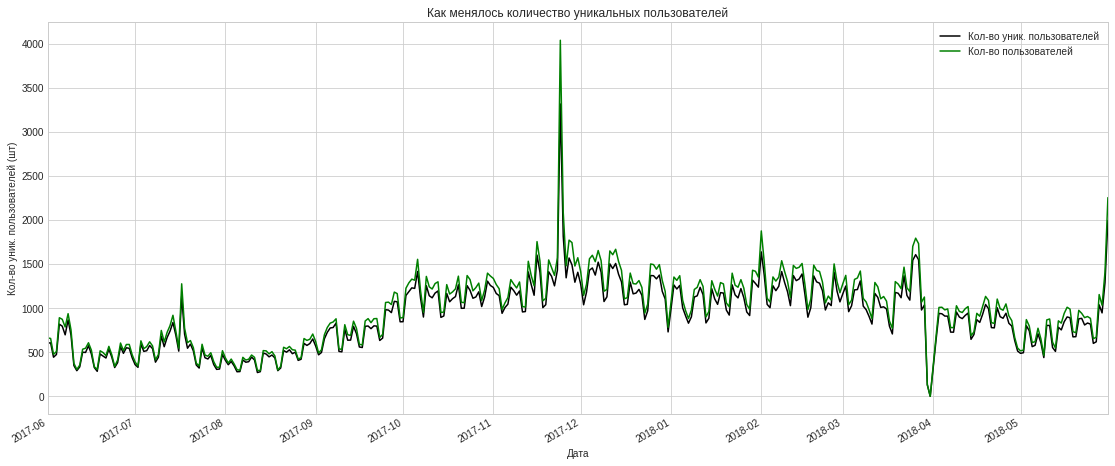

In [15]:
mau_total = df1.groupby(['year', 'month']).agg({'uid': 'nunique'}).mean()
dau_total = df1.groupby('date').agg({'uid': 'nunique'}).mean()
wau_total = df1.groupby(['year', 'week']).agg({'uid': 'nunique'}).mean()


print(f"Daily active users: {int(dau_total)}")
print(f"Weekly active users: {int(wau_total)}")
print(f"Monthly active users: {int(mau_total)}")


ax1 = df1.groupby('date').agg({'uid': ['nunique', 'count']}).plot(figsize=(19,8),color=['black', 'green'])
plt.legend(['Кол-во уник. пользователей', 'Кол-во пользователей'])
plt.title('Как менялось количество уникальных пользователей')
ax1.set_xlabel('Дата')
ax1.set_ylabel('Кол-во уник. пользователей (шт)')
plt.show()

<a id="2.2"></a>
### Как часто люди возвращаются?

Посчитаем сначала sticky factor.

In [16]:
sticky_mau = dau_total / mau_total * 100
sticky_wau = dau_total / wau_total * 100

print(f"sticky_mau: {sticky_mau[0]:8.2f}")
print(f"sticky_wau: {sticky_wau[0]:8.2f}")


sticky_mau:     3.91
sticky_wau:    15.88


Видим неплохой недельный показаетель. А вот над месячным стоит поработать.

#### Рассчитаем также retention rate

In [17]:
df1['activity_date'] = pd.to_datetime(df1['start_ts'])

# Возьмём дату, когда пользователь впервые проявил активность
first_activity_date = df1.groupby(['uid'])['start_ts'].min()
first_activity_date.name = 'first_activity_date'

df1 = df1.merge(first_activity_date, on='uid')
df1['activity_month'] = df1['start_ts'].astype('datetime64[M]')
df1['first_activity_month'] = df1['first_activity_date'].astype('datetime64[M]')

# установим, сколько существует когорта
df1['cohort_lifetime'] = df1['activity_month'] - df1['first_activity_month']
df1['cohort_lifetime'] = df1['cohort_lifetime'] / np.timedelta64(1,'M')
df1['cohort_lifetime'] = df1['cohort_lifetime'].round().astype('int')

# Сгруппируем данные по когорте и lifetime. Посчитаем для когорт количество активных пользователей на определённую неделю жизни
cohorts = df1.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

# Найдём исходное количество пользователей в когорте. Возьмём их число на нулевой месяц
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

# Объединим данные по когортам с исходным количеством пользователей в когорте
cohorts = cohorts.merge(initial_users_count,on='first_activity_month')

# рассчитаем retention rate
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

retention_pivot = cohorts.pivot_table(index='first_activity_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Для наглядности построим хитмэп без 100-процентного значения.

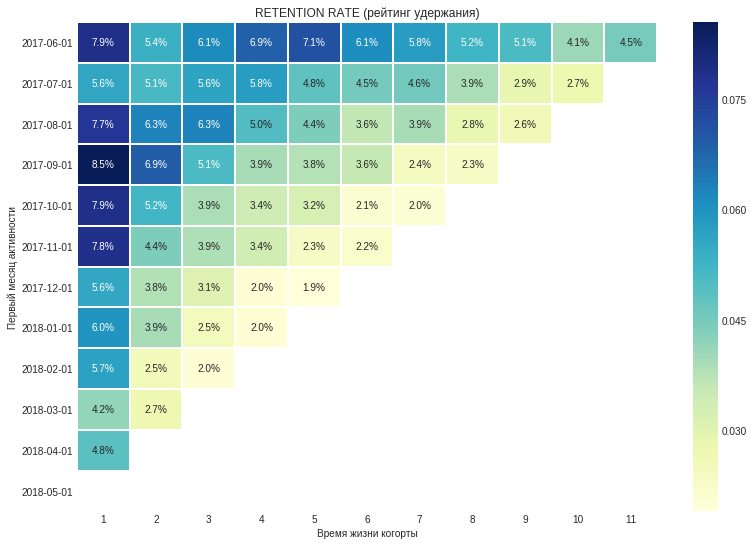

In [18]:
plt.figure(figsize=(13, 9))
plt.title('RETENTION RATE (рейтинг удержания)')

ax = sns.heatmap(retention_pivot.drop(columns=0), annot=True, fmt='.1%', linewidths=1, cmap="YlGnBu")
ax.set_xlabel("Время жизни когорты")
ax.set_ylabel("Первый месяц активности")
ax.set_yticklabels(retention_pivot.index.date)
plt.show()

Плохие результаты показывает декабрьская когорта 2017 года - хотя зимой услуги Афиши должны быть популярны. Довольно низкий коэффициент удержания и у мартовской когорты 2018 года. У июньской когорты 2017 года неплохие показатели. Правда, начиная с шестого месяца они падали - вплоть до последнего, одиннадцатого.

В целом retention rate обычно не превышает 5% - это не очень хороший показатель для такого сервиса как Афиша.

### Посмотрим на retention rate в разрезе различных устройств - мобильных и десктопа.

In [19]:
# retention_pivot
# cohorts
first_device = df1.sort_values(by = 'start_ts', ascending = True).groupby(['uid']).agg({'device':'first'}).reset_index()
first_device.columns = ['uid', 'first_device']
first_device

,uid,first_device
0,11863502262781,touch
1,49537067089222,touch
2,297729379853735,desktop
3,313578113262317,desktop
4,325320750514679,desktop
...,...,...
228164,18446403737806311543,desktop
228165,18446424184725333426,touch
228166,18446556406699109058,touch
228167,18446621818809592527,desktop


In [20]:
joint = first_device.merge(df1)

# roi = roi.fillna(0)
joint

,uid,first_device,device,end_ts,source_id,start_ts,date,week,month,year,duration_sec,activity_date,first_activity_date,activity_month,first_activity_month,cohort_lifetime
0,11863502262781,touch,touch,2018-03-01 17:33:00,3,2018-03-01 17:27:00,2018-03-01,9,3,2018,360,2018-03-01 17:27:00,2018-03-01 17:27:00,2018-03-01,2018-03-01,0
1,49537067089222,touch,touch,2018-02-06 15:57:00,2,2018-02-06 15:55:00,2018-02-06,6,2,2018,120,2018-02-06 15:55:00,2018-02-06 15:55:00,2018-02-01,2018-02-01,0
2,297729379853735,desktop,desktop,2017-06-07 18:48:00,3,2017-06-07 18:47:00,2017-06-07,23,6,2017,60,2017-06-07 18:47:00,2017-06-07 18:47:00,2017-06-01,2017-06-01,0
3,313578113262317,desktop,desktop,2018-03-11 17:29:00,2,2018-03-11 17:23:00,2018-03-11,10,3,2018,360,2018-03-11 17:23:00,2017-09-18 22:49:00,2018-03-01,2017-09-01,6
4,313578113262317,desktop,desktop,2017-09-18 23:07:00,2,2017-09-18 22:49:00,2017-09-18,38,9,2017,1080,2017-09-18 22:49:00,2017-09-18 22:49:00,2017-09-01,2017-09-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359395,18446424184725333426,touch,touch,2017-12-06 20:32:00,4,2017-12-06 20:32:00,2017-12-06,49,12,2017,0,2017-12-06 20:32:00,2017-12-06 20:32:00,2017-12-01,2017-12-01,0
359396,18446556406699109058,touch,touch,2018-01-01 16:31:00,3,2018-01-01 16:29:00,2018-01-01,1,1,2018,120,2018-01-01 16:29:00,2018-01-01 16:29:00,2018-01-01,2018-01-01,0
359397,18446621818809592527,desktop,desktop,2018-05-21 09:45:00,4,2018-05-21 09:30:00,2018-05-21,21,5,2018,900,2018-05-21 09:30:00,2017-12-27 13:27:00,2018-05-01,2017-12-01,5
359398,18446621818809592527,desktop,desktop,2017-12-27 14:08:00,4,2017-12-27 13:27:00,2017-12-27,52,12,2017,2460,2017-12-27 13:27:00,2017-12-27 13:27:00,2017-12-01,2017-12-01,0


In [21]:
cohorts1 = joint.groupby(['first_activity_month','cohort_lifetime', 'first_device']).agg({'uid':'nunique'}).reset_index()
 
initial_users_count1 = cohorts1[cohorts1['cohort_lifetime'] == 0][['first_activity_month','uid', 'first_device']]
 
initial_users_count1 = initial_users_count1.rename(columns={'uid':'cohort_users'})
 
cohorts1 = cohorts1.merge(initial_users_count1,on=['first_activity_month', 'first_device'])
 
cohorts1['retention'] = cohorts1['uid']/cohorts1['cohort_users']


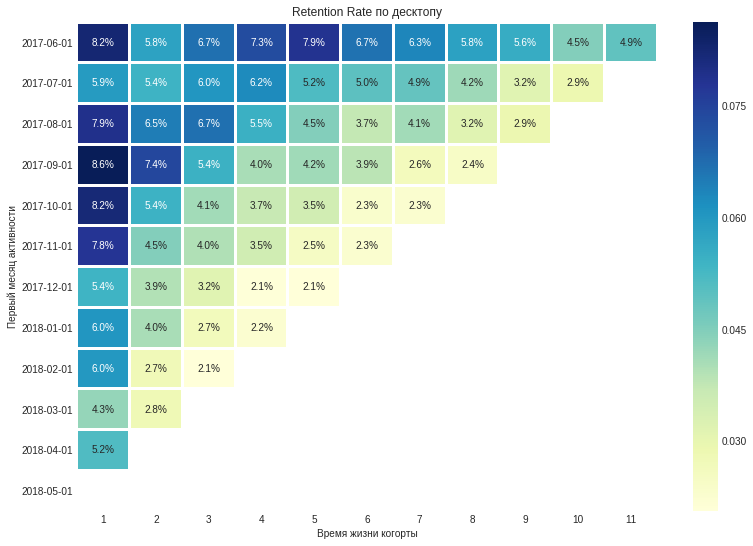

In [22]:
retention_pivot_desktop = (cohorts1.query('first_device == "desktop"')).pivot_table(index='first_activity_month',columns='cohort_lifetime',values='retention')
plt.figure(figsize=(13, 9))
plt.title('Retention Rate по десктопу')
ax = sns.heatmap(retention_pivot_desktop.drop(columns=0), annot=True, fmt='.1%', linewidths=2, cmap="YlGnBu")
ax.set_xlabel("Время жизни когорты")
ax.set_ylabel("Первый месяц активности")
ax.set_yticklabels(retention_pivot.index.date)
plt.show()


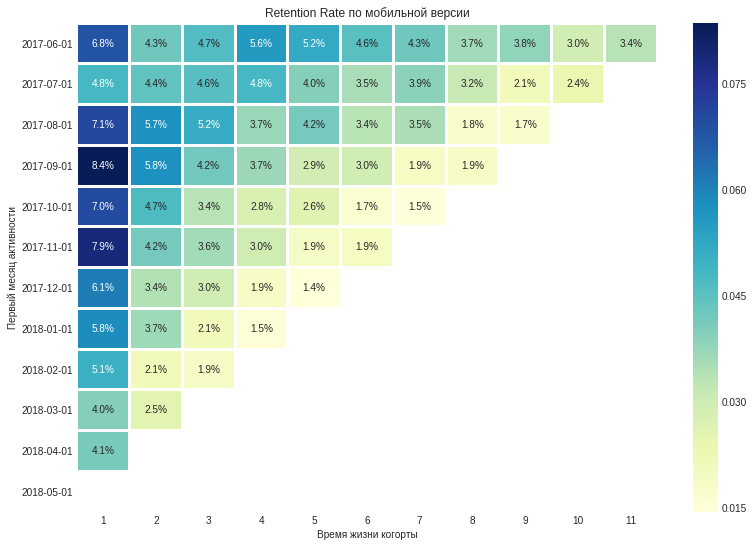

In [23]:
retention_pivot_touch = (cohorts1.query('first_device == "touch"')).pivot_table(index='first_activity_month',columns='cohort_lifetime',values='retention')
plt.figure(figsize=(13, 9))
plt.title('Retention Rate по мобильной версии')
ax = sns.heatmap(retention_pivot_touch.drop(columns=0), annot=True, fmt='.1%', linewidths=2, cmap="YlGnBu")
ax.set_xlabel("Время жизни когорты")
ax.set_ylabel("Первый месяц активности")
ax.set_yticklabels(retention_pivot.index.date)
plt.show()



В сравнении мы видим, что чаще возвращаются к продукту те клиенты, которые сидят с десктопа. Хотя большой разницы между пользователями на разных устройствах по этой метрике нет. Особенно хорошие показатели у десктопной когорты, которая пришла в июне 2017 года. Среди пользователей мобильной версии лучше всего возвращатся летние когорты 2017 года.

<a id="2.3"></a>
### Сколько длится одна сессия?

In [24]:
df1['session_duration_sec'] = (df1['end_ts'] - df1['start_ts']).dt.seconds
print('Одна сессия в среднем длится (сек):', df1['session_duration_sec'].mean())


Одна сессия в среднем длится (сек): 643.506488592098


Text(0, 0.5, 'Пользователи')

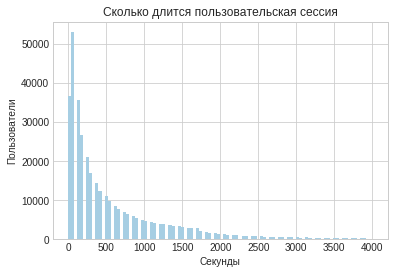

In [78]:
# Взглянем на распределение
ax3 = df1['session_duration_sec'].hist(bins=100, range=(0, 4000))
ax3.set_title('Сколько длится пользовательская сессия')
ax3.set_xlabel('Секунды')
ax3.set_ylabel('Пользователи')

Распределение не нормальное, поэтому посчитаем моду - значение в выборке, которое встречается чаще всего

In [26]:
# рассчитаем моду - значение в выборке, которое встречается чаще всего:
df1['session_duration_sec'].mode()

0    60
dtype: int64

Большинство сессий длится 60 секунд. Вряд ли за это время можно выбрать фильм/спектакль/концерт и т.д. и оформить

<a id="2.4"></a>
### Сколько сессий в день?

In [27]:
sessions_per_user = df1.groupby('date').agg({'uid': ['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
sessions_per_user.mean()

n_sessions           987.362637
n_users              907.991758
sessions_per_user      1.082170
dtype: float64

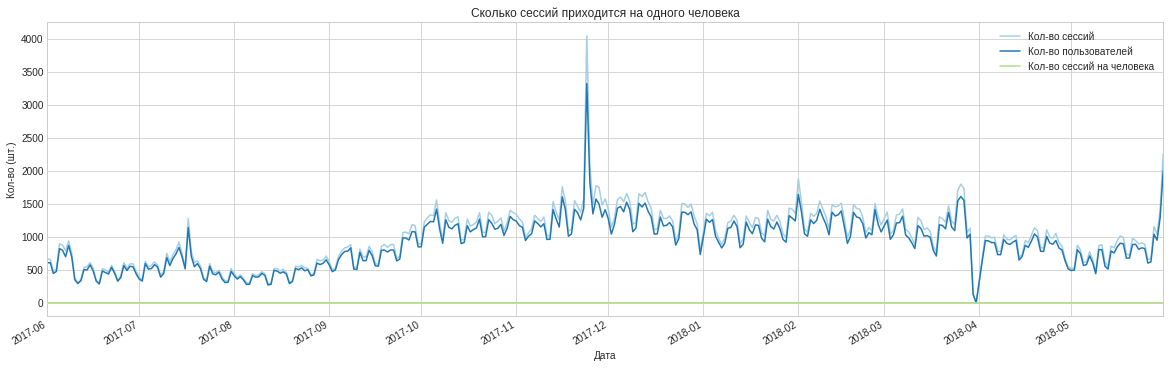

In [80]:
ax4 = sessions_per_user.plot(figsize=(20, 6))
plt.legend(['Кол-во сессий', 'Кол-во пользователей', 'Кол-во сессий на человека'])
ax4.set_title('Сколько сессий приходится на одного человека')
ax4.set_xlabel('Дата')
ax4.set_ylabel('Кол-во (шт.)')
plt.show()

Один пользователь обычно заходит на сайт один раз в день.

<a id="3"></a>
## Продажи


<a id="3.1"></a>
### Когда люди начинают покупать?

In [29]:
df2['order_date'] = df2['buy_ts'].dt.date
df2['order_day'] = df2['buy_ts'].dt.day
df2['order_month'] = df2['buy_ts'].dt.month
df2['order_year'] = df2['buy_ts'].dt.year
df2['order_week'] = df2['buy_ts'].dt.week
df2['order_minute'] = df2['buy_ts'].dt.minute

In [30]:


# df4 = df1.merge(df2, on='uid')
# first_order_date = df4.groupby(['uid'])['buy_ts'].min()
# first_order_date.name = 'first_order_date'

# df4 = df4.merge(first_order_date, on='uid')
# df4['first_order_day'] = df4['first_order_date'].astype('datetime64[D]')
# df4['first_activity_day'] = df4['first_activity_month'].astype('datetime64[D]')
# df4['buy_start'] = (df4['first_order_day'] - df4['first_activity_day'])/np.timedelta64(1, 'm')



# print('Значение mode:', df4['buy_start'].mode())
# print('Среднее значение:', df4['buy_start'].mean())
# print('Медианное значение:', df4['buy_start'].median())

In [31]:
first_order_date = df2.groupby('uid')[['buy_ts']].min().reset_index()
first_order_date.columns = ['uid', 'first_order_date']
first_activity_date = df1.groupby('uid')[['start_ts']].min().reset_index()
first_activity_date.columns = ['uid', 'first_activity']

In [32]:
df4 = first_order_date.merge(first_activity_date, on='uid')

In [33]:
df4['buy_start'] = df4['first_order_date'] - df4['first_activity']
df4['buy_start'] = df4['buy_start']/np.timedelta64(1, 'm')
df4['buy_start'] = df4['buy_start'].round(1)
df4.head(10)

,uid,first_order_date,first_activity,buy_start
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,154022.0
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0.0
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,79.0
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,1184.0
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0.0
5,3077748354309989,2018-03-03 12:33:00,2018-03-03 12:08:00,25.0
6,3605148382144603,2017-09-21 20:56:00,2017-08-15 21:54:00,53222.0
7,3753586865891862,2018-03-03 13:50:00,2018-03-03 13:47:00,3.0
8,4808417689019433,2018-01-09 23:32:00,2018-01-09 23:10:00,22.0
9,4992223027560440,2018-04-04 13:54:00,2018-04-04 13:54:00,0.0


In [34]:
df4['buy_start'].describe()

count     36523.000000
mean      24340.175834
std       67784.774690
min           0.000000
25%           4.000000
50%          16.000000
75%        2897.000000
max      523144.000000
Name: buy_start, dtype: float64

In [35]:
print('Значение mode:', df4['buy_start'].mode())
print('Среднее значение:', df4['buy_start'].mean())
print('Медианное значение:', df4['buy_start'].median())

Значение mode: 0    1.0
dtype: float64
Среднее значение: 24340.175834405716
Медианное значение: 16.0


По нашим подсчетам, большинство пользователей совершают покупку в течение 1 минуты после появления на сайте. Медианное значение - 16 минут. Среднее значение довольно большое из-за выбросов.

<a id="3.2"></a>
### Сколько раз покупают за период?

Заказов ежедневно: 138
Заказов еженедельно: 951
Заказов ежемесячно: 3878


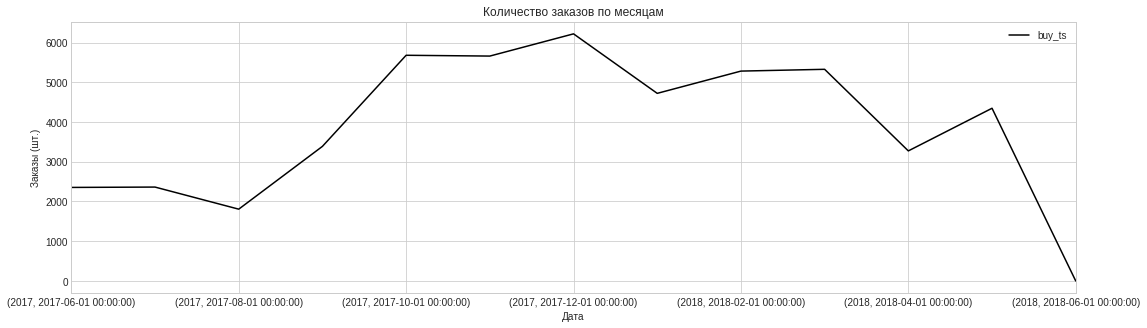

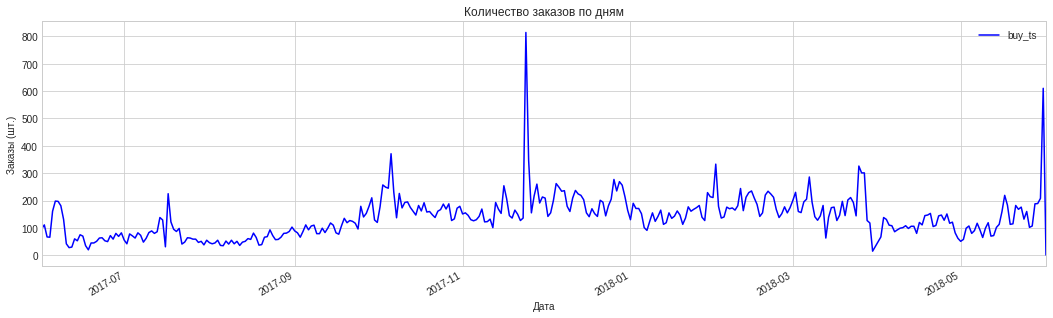

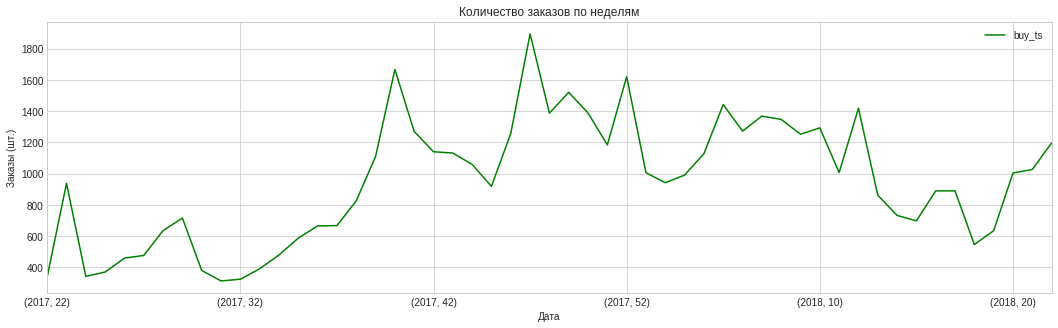

In [83]:
orders_month = df2.groupby(['order_year', 'order_month']).agg({'buy_ts': 'count'}).mean()
orders_date = df2.groupby('order_date').agg({'buy_ts': 'count'}).mean()
orders_week = df2.groupby(['order_year', 'order_week']).agg({'buy_ts': 'count'}).mean()


print(f"Заказов ежедневно: {int(orders_date)}")
print(f"Заказов еженедельно: {int(orders_week)}")
print(f"Заказов ежемесячно: {int(orders_month)}")

ax5 = df2.groupby(['order_year', 'order_month']).agg({'buy_ts': 'count'}).plot(figsize=(18,5), color='black')
plt.title('Количество заказов по месяцам')
ax5.set_xlabel('Дата')
ax5.set_ylabel('Заказы (шт.)')
ax6 = df2.groupby('order_date').agg({'buy_ts': 'count'}).plot(figsize=(18,5), color='blue')
ax6.set_xlabel('Дата')
ax6.set_ylabel('Заказы (шт.)')
plt.title('Количество заказов по дням')
ax7 = df2.groupby(['order_year', 'order_week']).agg({'buy_ts': 'count'}).plot(figsize=(18,5), color='green')
ax7.set_xlabel('Дата')
ax7.set_ylabel('Заказы (шт.)')
plt.title('Количество заказов по неделям')
plt.show()

Видно, что в летние месяцы заказов меньше.

Посчитаем также количество заказов для когорт. Расчёт проведём по аналогии с LTV, только подсчитаем количествово заказов, а не выручку, и поделим их на количество покупателей.

In [37]:
df2['order_date'] = pd.to_datetime(df2['order_date'])
df2['order_month'] = df2['order_date'].astype('datetime64[M]')


first_orders = df2.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']
# first_orders['first_order_month'] = first_orders['first_order_month'].astype('datetime64[M]')
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
first_orders

,uid,first_order_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01
...,...,...
36518,18445147675727495770,2017-11-01
36519,18445407535914413204,2017-09-01
36520,18445601152732270159,2018-03-01
36521,18446156210226471712,2018-02-01


In [38]:

orders_first_month = pd.merge(df2, first_orders, on='uid')

cohorts = orders_first_month.groupby(['first_order_month', 'order_month']).agg({'revenue': 'count'}).reset_index()
report = pd.merge(cohort_sizes, cohorts, on='first_order_month') # объедините cohorts и cohort_sizes
report.columns = ['first_order_month', 'n_buyers', 'order_month', 'orders_count']
report


,first_order_month,n_buyers,order_month,orders_count
0,2017-06-01,2023,2017-06-01,2354
1,2017-06-01,2023,2017-07-01,177
2,2017-06-01,2023,2017-08-01,174
3,2017-06-01,2023,2017-09-01,226
4,2017-06-01,2023,2017-10-01,292
...,...,...,...,...
74,2018-03-01,3533,2018-05-01,176
75,2018-04-01,2276,2018-04-01,2495
76,2018-04-01,2276,2018-05-01,195
77,2018-05-01,2988,2018-05-01,3249


In [39]:
report['first_order_month'] = pd.to_datetime(report['first_order_month'], format='%d-%m-%Y')


In [40]:
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

report['orders_per_user'] = report['orders_count'] / report['n_buyers']
# report['average_revenue'] = report['revenue_sum'] / report['n_buyers']



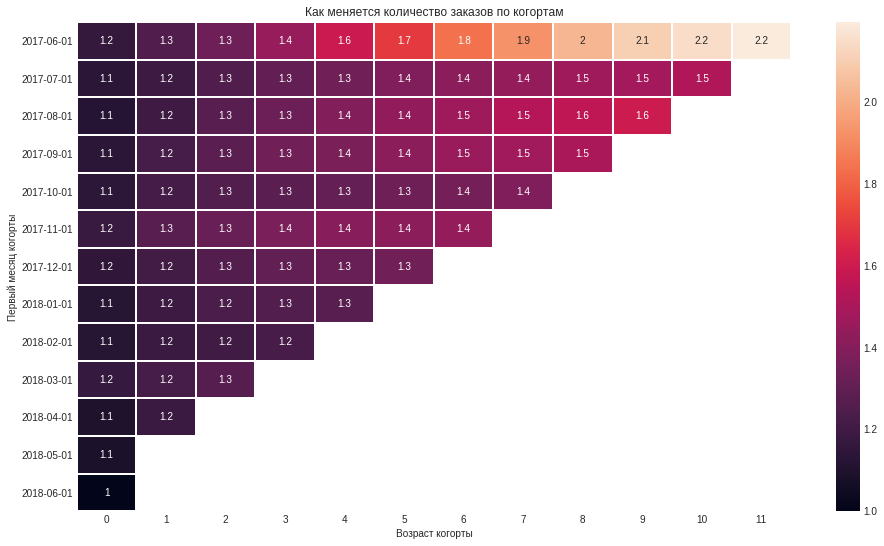

In [84]:
# report['first_order_month'] = report['first_order_month'].dt.strftime('%d-%m-%Y')
result = report.pivot_table(
        index='first_order_month',
        columns='age',
        values='orders_per_user',
        aggfunc='mean').cumsum(axis=1)

# result['first_order_month'] = result['first_order_month'].astype('string')

plt.figure(figsize = (16, 9))
ax = sns.heatmap(result, annot=True, linewidths=1)
plt.title('Как меняется количество заказов по когортам')
ax.set_xlabel('Возраст когорты')
ax.set_ylabel('Первый месяц когорты')
ax.set_yticklabels(result.index.date)
plt.show()

Июньская когорта 2017 года показывает наилучшие результаты - количество покупок растёт с каждым месяцем. У остальных когорт тоже неплохая динамика.

<a id="3.3"></a>
### Какой средний чек?

In [42]:
print('Средний чек:', df2['revenue'].sum() / len(df2))

Средний чек: 4.999646930477041


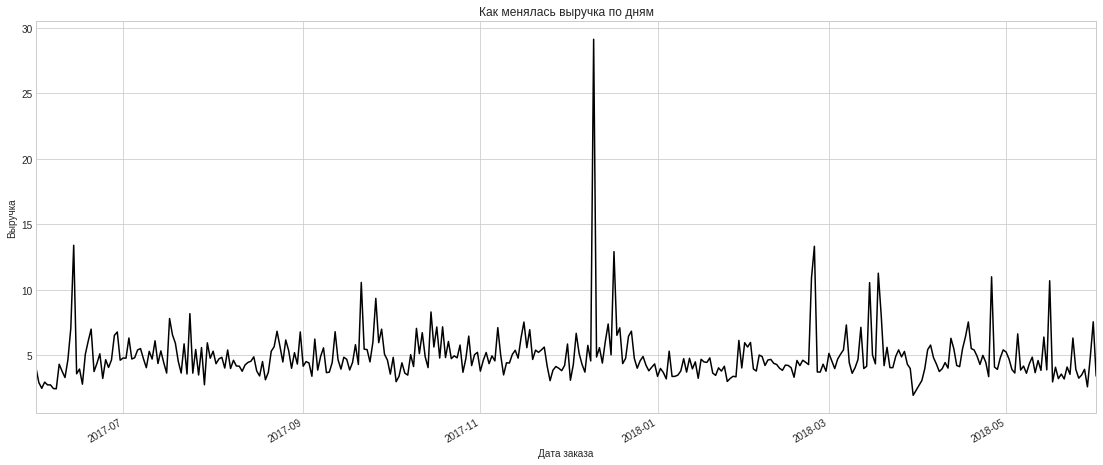

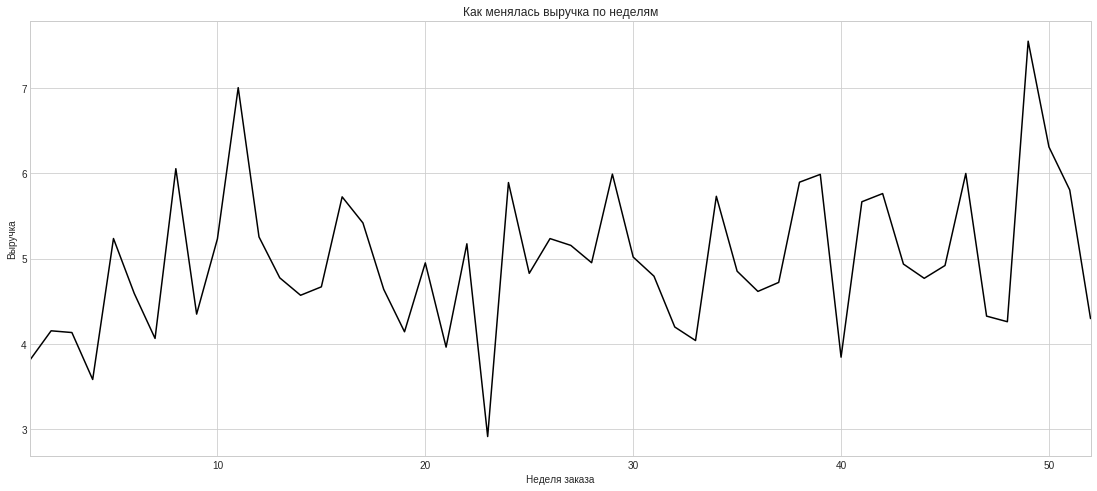

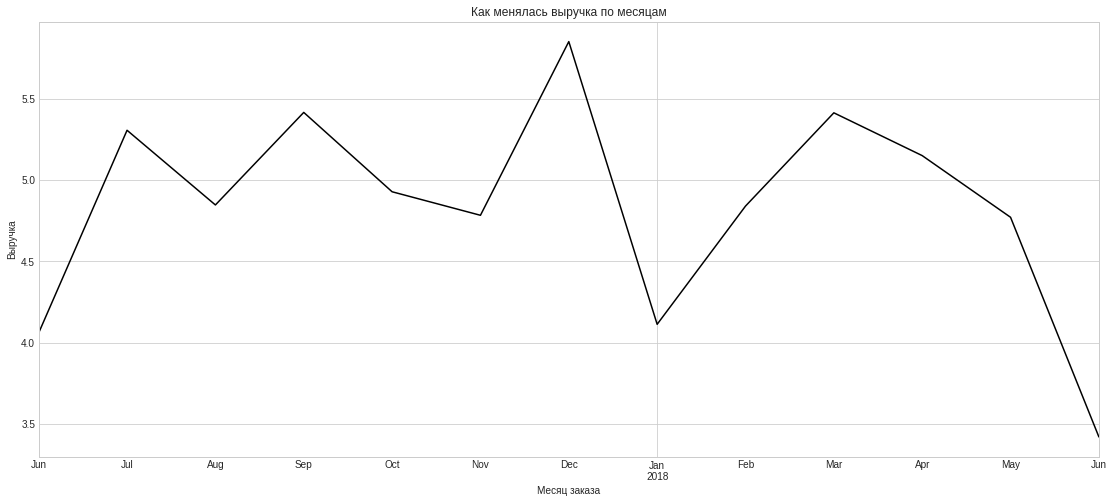

In [86]:
ax8 = df2.groupby('order_date')['revenue'].mean().plot(figsize=(19,8), color='black')
ax8.set_xlabel('Дата заказа')
ax8.set_ylabel('Выручка')
plt.title('Как менялась выручка по дням')
plt.show()

ax9 = df2.groupby('order_week')['revenue'].mean().plot(figsize=(19,8), color='black')
ax9.set_xlabel('Неделя заказа')
ax9.set_ylabel('Выручка')
plt.title('Как менялась выручка по неделям')
plt.show()

ax10 = df2.groupby('order_month')['revenue'].mean().plot(figsize=(19,8), color='black')
ax10.set_xlabel('Месяц заказа')
ax10.set_ylabel('Выручка')
plt.title('Как менялась выручка по месяцам')
plt.show()


В декабре тратят больше всего. Возможно, это связано с покупкой новогодних подарков. Меньше всего пользователи тратят в июне - летом не очень много мероприятий и кинопремьер.

<a id="3.4"></a>
### Сколько денег приносят продажи? (LTV)

In [44]:
df2['order_month'] = df2['order_date'].astype('datetime64[M]')

# получим месяц первой покупки каждого покупателя
first_orders = df2.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

# посчитаем количество новых покупателей (n_buyers) за каждый месяц
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

# маржа не задана, поэтому примем её за единицу
margin_rate = 1 

# построим когорты. Добавим месяц первой покупки каждого покупателя в таблицу с заказами
orders_first_month = pd.merge(df2, first_orders, on='uid')

# Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку
cohorts = orders_first_month.groupby(['first_order_month', 'order_month']).agg({'revenue': 'sum'}).reset_index()

# Добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц
rep = pd.merge(cohort_sizes, cohorts, on='first_order_month') 

rep['gp'] = rep['revenue'] * margin_rate

rep['age'] = (rep['order_month'] - rep['first_order_month']) / np.timedelta64(1, 'M')

rep['age'] = rep['age'].round().astype('int')
# посчитаем LTV когорт
rep['ltv'] = rep['gp'] / rep['n_buyers'] 

ltv_pivot = rep.pivot_table(
            index='first_order_month',
            columns='age',
            values='ltv',
            aggfunc='mean').cumsum(axis=1).round(2) 

display(ltv_pivot)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.60,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.50,7.66,7.78,7.92,8.08,8.23,8.39,NaN
2017-08-01,5.28,5.75,6.21,6.60,7.09,7.38,7.59,7.99,8.28,8.47,NaN,NaN
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,NaN,NaN,NaN
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,NaN,NaN,NaN,NaN
2017-11-01,5.15,5.55,5.75,6.08,6.23,6.28,6.40,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.74,5.00,5.92,6.99,7.30,7.64,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.14,4.43,4.73,4.88,4.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.16,4.44,4.51,4.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


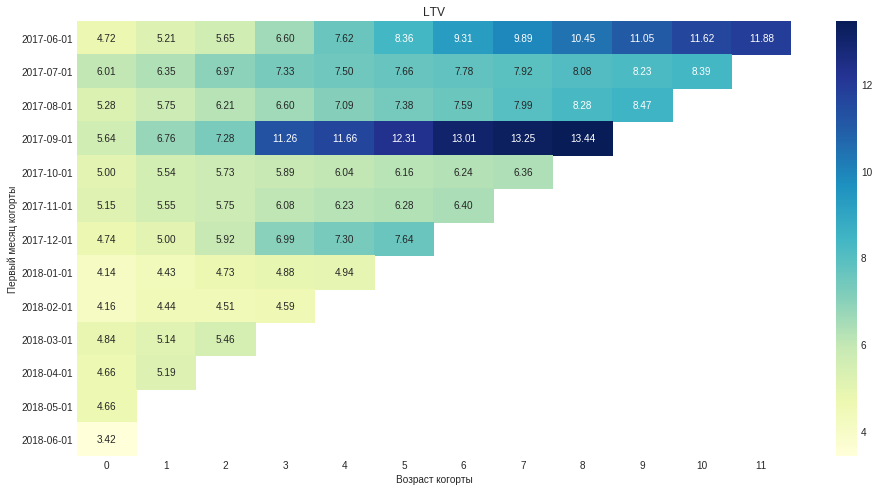

In [87]:
fig, ax = plt.subplots(figsize=(16,8))
ax = sns.heatmap(ltv_pivot, cmap="YlGnBu", annot=True, fmt='.2f')
ax.set_xlabel('Возраст когорты')
ax.set_ylabel('Первый месяц когорты')
plt.title('LTV')
ax.set_yticklabels(ltv_pivot.index.date)
plt.show()

Мы посчитали ltv, но, не зная сас, нельзя точно сказать, хорошие это показатели или плохие. Позднее мы посчитаем, насколько окупились затраты компании.

Посчитаем усреднённый LTV для первых шести когорт за шесть месяцев:

### Посчитаем LTV в разрезе разных устройств - мобильных и десктопов.

In [46]:
merged = df2.merge(first_device)

orders_first_month1 = pd.merge(merged, first_orders, on='uid')

In [47]:
cohorts1 = orders_first_month1.groupby(['first_order_month', 'order_month', 'first_device']).agg({'revenue': 'sum'}).reset_index()

rep1 = pd.merge(cohort_sizes, cohorts1, on='first_order_month') 

rep1['gp'] = rep1['revenue'] * margin_rate

rep1['age'] = (rep1['order_month'] - rep1['first_order_month']) / np.timedelta64(1, 'M')

rep1['age'] = rep1['age'].round().astype('int')

rep1['ltv'] = rep1['gp'] / rep1['n_buyers']

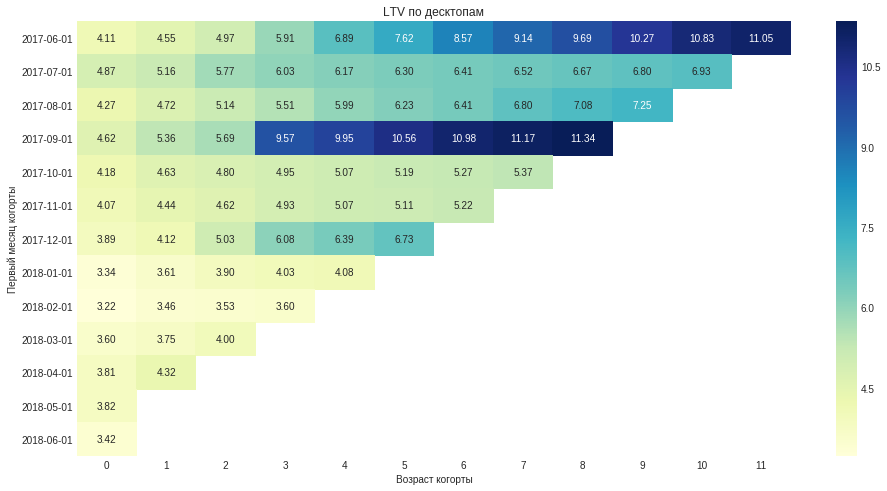

In [88]:
ltv_pivot_desktop = (rep1.query('first_device == "desktop"')).pivot_table(
            index='first_order_month',
            columns='age',
            values='ltv',
            aggfunc='mean').cumsum(axis=1).round(2) 

fig, ax = plt.subplots(figsize=(16,8))
ax = sns.heatmap(ltv_pivot_desktop, cmap="YlGnBu", annot=True, fmt='.2f')
ax.set_xlabel('Возраст когорты')
ax.set_ylabel('Первый месяц когорты')
plt.title('LTV по десктопам')
ax.set_yticklabels(ltv_pivot.index.date)
plt.show()

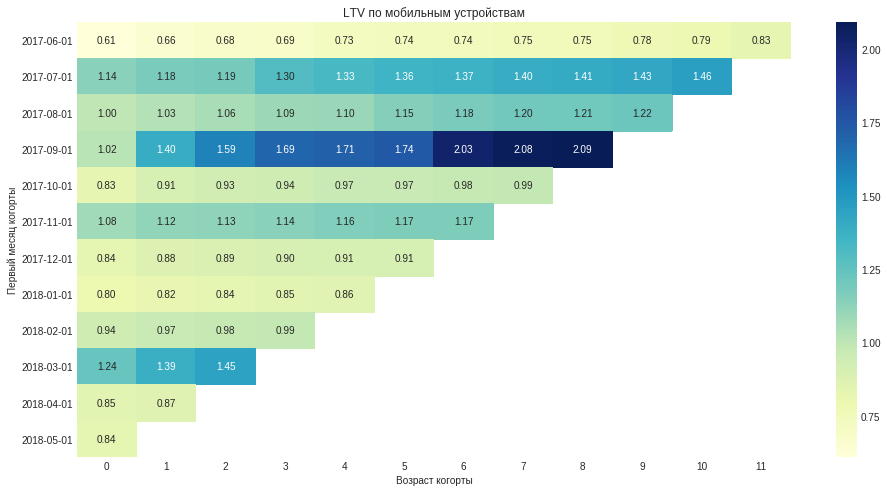

In [89]:
ltv_pivot_touch = (rep1.query('first_device == "touch"')).pivot_table(
            index='first_order_month',
            columns='age',
            values='ltv',
            aggfunc='mean').cumsum(axis=1).round(2) 

fig, ax = plt.subplots(figsize=(16,8))
ax = sns.heatmap(ltv_pivot_touch, cmap="YlGnBu", annot=True, fmt='.2f')
ax.set_xlabel('Возраст когорты')
ax.set_ylabel('Первый месяц когорты')
plt.title('LTV по мобильным устройствам')
ax.set_yticklabels(ltv_pivot.index.date)
plt.show()

Метрика LTV в разрезе по устройства показывает, что куда более ценными для компании являются пользователи десктопов. По сравнению с ними пользователи мобильных устройств имеют очень низкую LTV.
В целом стоит отметить хорошие результаты первых семи когорт - LTV в них растёт с каждым месяцем.

Поскольку LTV - метрика условно бесконечная, то посмотрим на неё за определённый период - для первых 6 когорт за 6 месяцев.

In [90]:
m6_cum_ltv = ltv_pivot.mean(axis=0)[5]
m6_cum_ltv

7.970000000000001

<a id="4"></a>

### Маркетинг


In [51]:
df3

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


In [52]:
df3['date'] = df3['dt'].dt.date
df3['week'] = df3['dt'].dt.week
df3['month'] = df3['dt'].dt.month
df3['year'] = df3['dt'].dt.year
df3['month'] = df3['date'].astype('datetime64[M]')

<a id="4.1"></a>
### Сколько денег потратили? Всего / на каждый источник / по времени

Всего потратили на маркетинг: 329131.62


,costs
year,
2017,187961.15
2018,141170.47


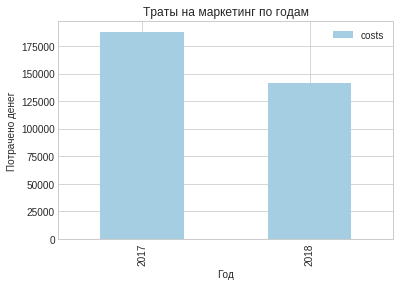

,costs
month,
2017-06-01,18015.00
2017-07-01,18240.59
2017-08-01,14790.54
2017-09-01,24368.91
2017-10-01,36322.88
2017-11-01,37907.88
2017-12-01,38315.35
2018-01-01,33518.52
2018-02-01,32723.03


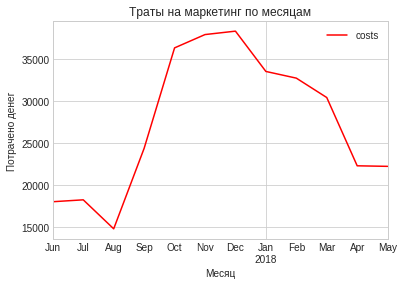

,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


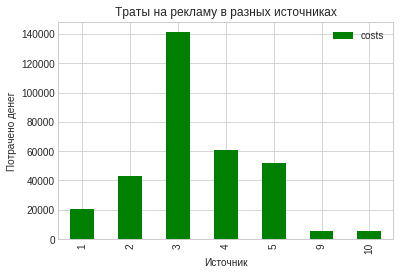

In [99]:
print('Всего потратили на маркетинг:', df3['costs'].sum())

display(df3.groupby('year').agg({'costs': 'sum'}))
ax11 = df3.groupby('year').agg({'costs': 'sum'}).plot(kind='bar', title='Траты на маркетинг по годам')
ax11.set_xlabel('Год')
ax11.set_ylabel('Потрачено денег')
plt.show()


display(df3.groupby('month').agg({'costs': 'sum'}))
ax12 = df3.groupby('month').agg({'costs': 'sum'}).plot(color='red', title='Траты на маркетинг по месяцам')
ax12.set_xlabel('Месяц')
ax12.set_ylabel('Потрачено денег')
plt.show()

display(df3.groupby('source_id').agg({'costs': 'sum'}))
ax13 = df3.groupby('source_id').agg({'costs': 'sum'}).plot(kind='bar', color='green', title='Траты на рекламу в разных источниках')
ax13.set_xlabel('Источник')
ax13.set_ylabel('Потрачено денег')
plt.show()

Больше всего на маркетинг тратили в октябре-декабре. Вложили больше всего в источник 3.

<a id="4.2"></a>
### Сколько стоило привлечение одного покупателя из каждого источника?

In [54]:
source_costs = df3.groupby('source_id').agg({'costs': 'sum'})
source_costs


,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


In [55]:

visits_by_source = df1.query('start_ts == first_activity_date')
users_by_source = df2.merge(visits_by_source, on='uid', how='inner')
users_by_source = users_by_source.groupby('source_id').agg({'uid':'nunique'}).rename(columns={'uid':'n_users'})

In [56]:
cac = users_by_source.join(source_costs).reset_index()
cac = cac.fillna(0)
cac

,source_id,n_users,costs
0,1,2899,20833.27
1,2,3506,42806.04
2,3,10473,141321.63
3,4,10296,61073.60
4,5,6931,51757.10
5,7,1,0.00
6,9,1088,5517.49
7,10,1329,5822.49


In [57]:
cac['user_cost'] = cac['costs'] / cac['n_users']
cac

,source_id,n_users,costs,user_cost
0,1,2899,20833.27,7.186364
1,2,3506,42806.04,12.209367
2,3,10473,141321.63,13.493901
3,4,10296,61073.60,5.931779
4,5,6931,51757.10,7.467479
5,7,1,0.00,0.000000
6,9,1088,5517.49,5.071222
7,10,1329,5822.49,4.381106


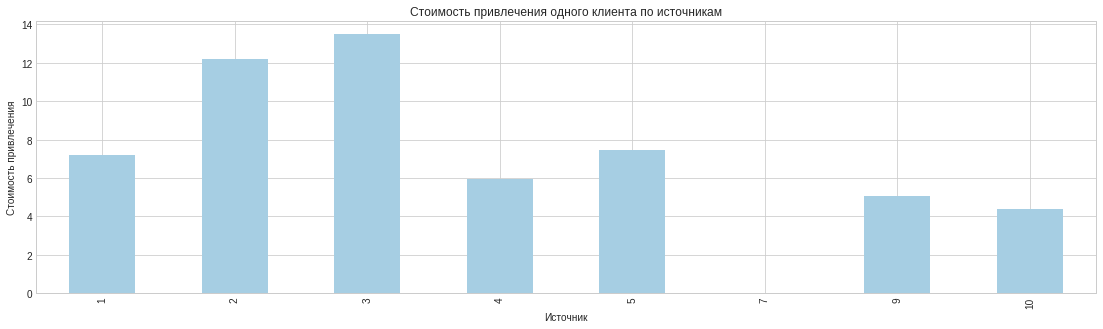

In [97]:
ax = cac.set_index('source_id')['user_cost'].plot(figsize=(19,5),kind='bar',title='Стоимость привлечения одного клиента по источникам')
ax.set_xlabel('Источник')
ax.set_ylabel('Стоимость привлечения')
plt.show()

Дороже всего компании обошлось привлечение клиентов из 3-го и 2-го источников. Не 7-й источник совсем не тратились.

<a id="4.3"></a>
### Насколько окупились расходы? (ROI)

In [59]:
revenue_by_source = df2.merge(visits_by_source, on='uid', how='inner')
revenue_by_source = revenue_by_source.groupby('source_id').agg({'revenue':'sum'})
revenue_by_source.reset_index()
revenue_by_source


,revenue
source_id,
1,31090.55
2,46923.61
3,54511.24
4,56696.83
5,52624.02
7,1.22
9,5759.40
10,4450.33


In [60]:
roi = revenue_by_source.join(source_costs, on='source_id', how='left')
roi = roi.fillna(0)
roi['roi (%)'] = (roi['revenue'] - roi['costs']) / roi['costs'] * 100
roi

,revenue,costs,roi (%)
source_id,,,
1,31090.55,20833.27,49.235094
2,46923.61,42806.04,9.619133
3,54511.24,141321.63,-61.427532
4,56696.83,61073.60,-7.166386
5,52624.02,51757.10,1.674978
7,1.22,0.00,inf
9,5759.40,5517.49,4.384421
10,4450.33,5822.49,-23.566550


Как мы видим, самым убыточным и не окупившим затраты оказался источник №3, в который компания вкладывала больше всего денег. Не окупились также затраты на источники №10 и №4. Наибольшую отдачу мы видим по источнику №1.

Если смотреть roi по устройствам, то окупается только привлечение десктопных клиентов из источника №1. Привлечение клиентов, которые заказывают с тач-устройств, не окупается.

In [62]:
monthly_roi = df3.groupby('month')['costs'].sum().to_frame('cost')
monthly_roi['revenue'] = df2.groupby(by='order_month')['revenue'].sum()
monthly_roi['roi (%)'] = (monthly_roi['revenue'] - monthly_roi['cost']) / monthly_roi['cost'] * 100
monthly_roi

,cost,revenue,roi (%)
month,,,
2017-06-01,18015.00,9557.49,-46.947044
2017-07-01,18240.59,12539.47,-31.255129
2017-08-01,14790.54,8758.78,-40.781202
2017-09-01,24368.91,18345.51,-24.717560
2017-10-01,36322.88,27987.70,-22.947465
2017-11-01,37907.88,27069.93,-28.590230
2017-12-01,38315.35,36388.60,-5.028663
2018-01-01,33518.52,19417.13,-42.070443
2018-02-01,32723.03,25560.54,-21.888224


По месяца roi всегда отрицательный. Ближе всего к нулю показатель в декабре, марте и мае.

In [63]:
# report_new = pd.merge(orders_new, monthly_costs, left_on=['first_order_month', 'first_source_id'], right_on= ['month', 'source_id'])


Также посчитаем средний чек по устройствам:

In [64]:
orders_by_device.groupby('device')['revenue'].agg('mean').to_frame()

,revenue
device,
desktop,26416.221250
touch,5818.204286


In [65]:
devices = df2.merge(visits_by_source, on='uid', how='inner')
devices

,buy_ts,revenue,uid,order_date,order_day,order_month,order_year,order_week,order_minute,device,...,week,month,year,duration_sec,activity_date,first_activity_date,activity_month,first_activity_month,cohort_lifetime,session_duration_sec
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,1,2017-06-01,2017,22,10,desktop,...,22,6,2017,120,2017-06-01 00:09:00,2017-06-01 00:09:00,2017-06-01,2017-06-01,0,120
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,1,2017-06-01,2017,22,25,desktop,...,22,6,2017,660,2017-06-01 00:14:00,2017-06-01 00:14:00,2017-06-01,2017-06-01,0,660
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,1,2017-06-01,2017,22,27,desktop,...,22,6,2017,540,2017-06-01 00:25:00,2017-06-01 00:25:00,2017-06-01,2017-06-01,0,540
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,1,2017-06-01,2017,22,29,desktop,...,22,6,2017,1140,2017-06-01 00:14:00,2017-06-01 00:14:00,2017-06-01,2017-06-01,0,1140
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,1,2017-06-01,2017,22,58,desktop,...,22,6,2017,1680,2017-06-01 07:31:00,2017-06-01 07:31:00,2017-06-01,2017-06-01,0,1680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31,31,2018-05-01,2018,22,50,touch,...,22,5,2018,60,2018-05-31 09:11:00,2018-05-31 09:11:00,2018-05-01,2018-05-01,0,60
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31,31,2018-05-01,2018,22,50,desktop,...,22,5,2018,3000,2018-05-31 23:05:00,2018-05-31 23:05:00,2018-05-01,2018-05-01,0,3000
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31,31,2018-05-01,2018,22,54,desktop,...,22,5,2018,180,2018-05-31 23:52:00,2018-05-31 23:52:00,2018-05-01,2018-05-01,0,180
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31,31,2018-05-01,2018,22,56,desktop,...,43,10,2017,240,2017-10-23 12:32:00,2017-10-23 12:32:00,2017-10-01,2017-10-01,0,240


<a id="5"></a>
### Общий вывод

В декабре пользователи Афиши тратят больше всего. Возможно, это связано с покупкой новогодних подарков. Меньше всего пользователи тратят в июне - и заказов меньше всего в летние месяцы. Возможно, потому, что летом не очень много мероприятий и кинопремьер. Но данные есть только за один год, поэтому нельзя точно говорить о сезонности.

Неплохие показатели с точки зрения метрики LTV имеют первые семь когорт - LTV в них растёт с каждым месяцем.

Когортный анализ показал, что количество заказов в разных когортах увеличивается. В целом же retention rate обычно не превышает 5% - это не очень хороший показатель для такого сервиса как Афиша. Стоит поработать над тем, чтобы пользователи чаще возвращались.

Я бы порекомендовал компании меньше инвестировать в источник трафика №3. Сейчас в него вкладывается больше всего денег, но эти траты не окупаются.

Освободившиеся деньги можно направить на привлечение клиентов из источника №1. ROI для него наибольший по сравнению с другими источниками - 49%. Также можно больше вкладывать в источники 2, 5 и 9 - для них ROI тоже оказался положительным (10%, 2% и 4% соответственно).

Позитивно можно оценить скорость, с которой пользователи продукта делают заказ - чаще всего на это уходит около одной минуты.

Привлекать лучше пользователей десктопов - они приносят больше прибыли, средний чек у них выше, чем у клиентов на мобильных устройствах. Метрика LTV в разрезе по устройствам также показывает, что куда более ценными для компании являются пользователи десктопов. По сравнению с ними пользователи мобильных устройств имеют очень низкую LTV.